# H&M Capstone 3 project - Data Wrangling and EDA

### The business problem is classifying new products into an existing taxonomy of product categories for online retail stores such as H&M

Product category is the variable we want to predict

- Features include product title, product description, one product image per 
- Each product has a unique article ID which is set as the index of the dataframe.


#### This notebook covers the scope of data cleaning, transforming and exploratory data analysis
1. Handle missing title or image data 
2. Product variants - color
3. Convert data types into appropriate ones for machine learning
4. Select the major product categories for prediction
5. What are the most frequently occuring words in the product title and product descriptions?
6. Visualizing high dimensional image embedding data
7. Compare the number of images vs. the number of products
8. Drop null values

## Imports

In [1]:
#pip install wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.manifold import TSNE
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
MAX_DICT_SIZE = 100
MIN_PRODUCTS_PER_CATEGORY = 200

## Load the dataset

In [4]:
hm_full_df = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/articles.csv', index_col='article_id')
df = hm_full_df
df.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
df.info

<bound method DataFrame.info of             product_code               prod_name  product_type_no  \
article_id                                                          
108775015         108775               Strap top              253   
108775044         108775               Strap top              253   
108775051         108775           Strap top (1)              253   
110065001         110065       OP T-shirt (Idro)              306   
110065002         110065       OP T-shirt (Idro)              306   
...                  ...                     ...              ...   
953450001         953450  5pk regular Placement1              302   
953763001         953763       SPORT Malaga tank              253   
956217002         956217         Cartwheel dress              265   
957375001         957375        CLAIRE HAIR CLAW               72   
959461001         959461            Lounge dress              265   

           product_type_name  product_group_name  graphical_appearance

In [6]:
# Look at an example product description
df.loc[110065001].detail_desc

'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.'

## 1. Handle missing product title or description

In [7]:
df[['prod_name','detail_desc','product_type_name']].isnull().sum()

prod_name              0
detail_desc          416
product_type_name      0
dtype: int64

The data is not missing any product titles. Missing product descriptions is ok since it is intended to supplement the product title.

In [8]:
# replace nulls with empty strings
df.fillna('', inplace=True, axis=1)
df[['prod_name','detail_desc','product_type_name']].isnull().sum()

prod_name            0
detail_desc          0
product_type_name    0
dtype: int64

## 2. Product variants - color
How frequently do products come in color variants? While color is a defining characteristic of a product, it shouldn't affect the product category the product belongs to. 

In [9]:
df.shape

(105542, 24)

In [10]:
product_variants = df.groupby(['product_code'])['prod_name'].count()
product_variants = product_variants.sort_values(ascending=False)
product_variants[:20]

product_code
783707    75
684021    70
699923    52
699755    49
685604    46
739659    44
664074    41
570002    41
562245    41
685816    41
619739    40
695632    40
688916    39
610776    39
570003    39
620208    39
570004    39
696991    38
807241    38
674606    38
Name: prod_name, dtype: int64

In [11]:
# Look into the first product code '783707' which has 75 variants:
df[df['product_code'] == 783707]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
783707002,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,9,Black,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707004,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707005,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,52,Pink,3,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707012,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707015,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783707164,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707167,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707168,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,93,Dark Green,2,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."


In [12]:
# Look at the description of these socks to see if they are the same
df[df['product_code'] == 783707].detail_desc.unique()

array(['Socks in a soft, jacquard-knit cotton blend with elasticated tops.'],
      dtype=object)

In [13]:
# Look at the color variants of the socks
df[df['product_code'] == 783707].colour_group_name.unique()

array(['Black', 'Dark Blue', 'Pink', 'Red', 'Light Green', 'Turquoise',
       'Grey', 'Light Grey', 'Dark Purple', 'Blue', 'Dark Turquoise',
       'Dark Grey', 'Purple', 'Light Blue', 'Dark Green', 'Orange',
       'Beige', 'Light Purple', 'Greenish Khaki', 'White', 'Light Yellow',
       'Light Turquoise', 'Dark Orange'], dtype=object)

This shows that the product '1pk Fun 1' or '1pk Fun' are socks that come in a variety of colors. For the purposes of product category classification, the 75 variants can be treated as a single product. 

### How many color variants are there across all products?

In [14]:
unique_colors = len(df['colour_group_name'].unique())
print(f'There are a total of {unique_colors} unique colors')


There are a total of 50 unique colors


In [15]:
color_counts = df.groupby('colour_group_name').count()['prod_name'].reset_index().sort_values(by='prod_name', ascending=False)
color_counts

,colour_group_name,prod_name
1,Black,22670
5,Dark Blue,12171
47,White,9542
24,Light Pink,5811
17,Grey,4487
19,Light Beige,3356
2,Blue,3308
42,Red,3056
20,Light Blue,3012
16,Greenish Khaki,2767


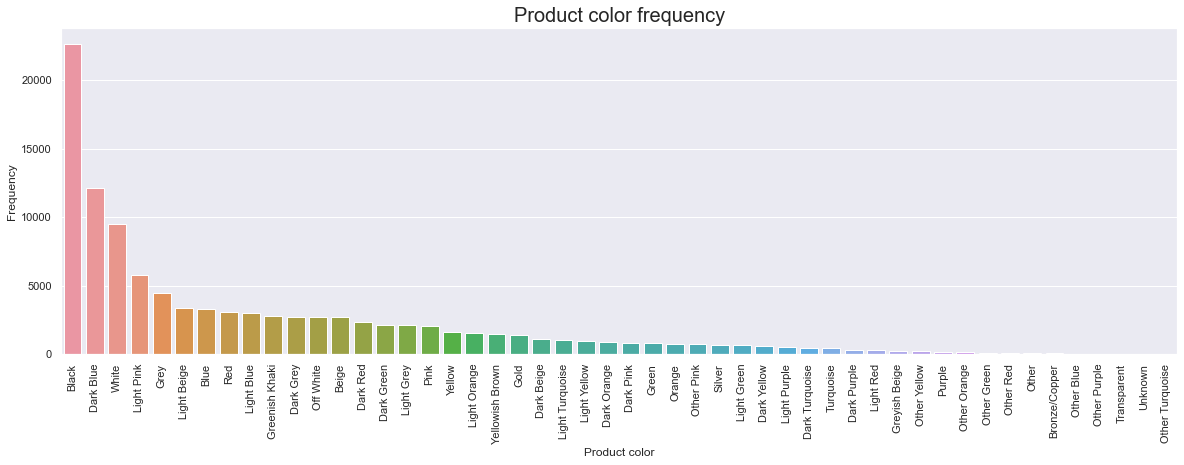

In [16]:
# Plot a barplot of this color frequency
ax = sns.set(rc={"figure.figsize":(20, 6)})
ax = sns.barplot(x='colour_group_name', y='prod_name', data=color_counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel ="Product color", ylabel = "Frequency")
ax.set_title('Product color frequency', size = 20)
plt.show()

The most common colors are neutral colors and black is the most frequently occuring product color. 

### Keep the color variants so image classification has more to learn from, but don't include color as a feature. 
A difference in color does not add any new information about the product to product category classification. The column 'product_code' is the same for all color variants of the same product. 


## 3. Convert data types into appropriate ones for machine learning

In [17]:
df[['prod_name','detail_desc','product_type_name']].dtypes

prod_name            object
detail_desc          object
product_type_name    object
dtype: object

In [18]:
# Convert object dtype to string
df[['prod_name','detail_desc','product_type_name']] = df[['prod_name','detail_desc','product_type_name']].astype("string")

In [19]:
df[['prod_name','detail_desc','product_type_name']].dtypes

prod_name            string
detail_desc          string
product_type_name    string
dtype: object

## 4. Select the major product categories for prediction
### The target variable is the product categories column 'product_type_name'

In [20]:
# Look at the product categories and how often they appear
print(f'There are {len(df.product_type_name.unique())} unique product categories')
df['product_type_name'].value_counts()

There are 131 unique product categories


Trousers         11169
Dress            10362
Sweater           9302
T-shirt           7904
Top               4155
                 ...  
Keychain             1
Headband             1
Cushion              1
Blanket              1
Clothing mist        1
Name: product_type_name, Length: 131, dtype: Int64

In [21]:
type_list = df.product_type_name.value_counts().reset_index()
# Select only major categories that have more than the variable 'MIN_PRODUCTS_PER_CATEGORY'
major_categories = type_list[type_list.product_type_name > MIN_PRODUCTS_PER_CATEGORY]['index']
list(major_categories)
print(f'There are a total of {len(major_categories)} major product categories')

There are a total of 53 major product categories


In [22]:
type_list[type_list.product_type_name > MIN_PRODUCTS_PER_CATEGORY]

,index,product_type_name
0,Trousers,11169
1,Dress,10362
2,Sweater,9302
3,T-shirt,7904
4,Top,4155
5,Blouse,3979
6,Jacket,3940
7,Shorts,3939
8,Shirt,3405
9,Vest top,2991


In [23]:
df = df[df.product_type_name.isin(major_categories)]
df.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [24]:
# Represent the product categories as a percentage
class_percentages = pd.DataFrame([(x / df.shape[0]) * 100.00 for x in df.product_type_name.value_counts()], index=df.product_type_name.value_counts().index)
class_percentages.columns = ['Percentage']
class_percentages = class_percentages.reset_index()
class_percentages

,index,Percentage
0,Trousers,10.917142
1,Dress,10.128339
2,Sweater,9.092242
3,T-shirt,7.725767
4,Top,4.061306
5,Blouse,3.889274
6,Jacket,3.851154
7,Shorts,3.850176
8,Shirt,3.328218
9,Vest top,2.923554


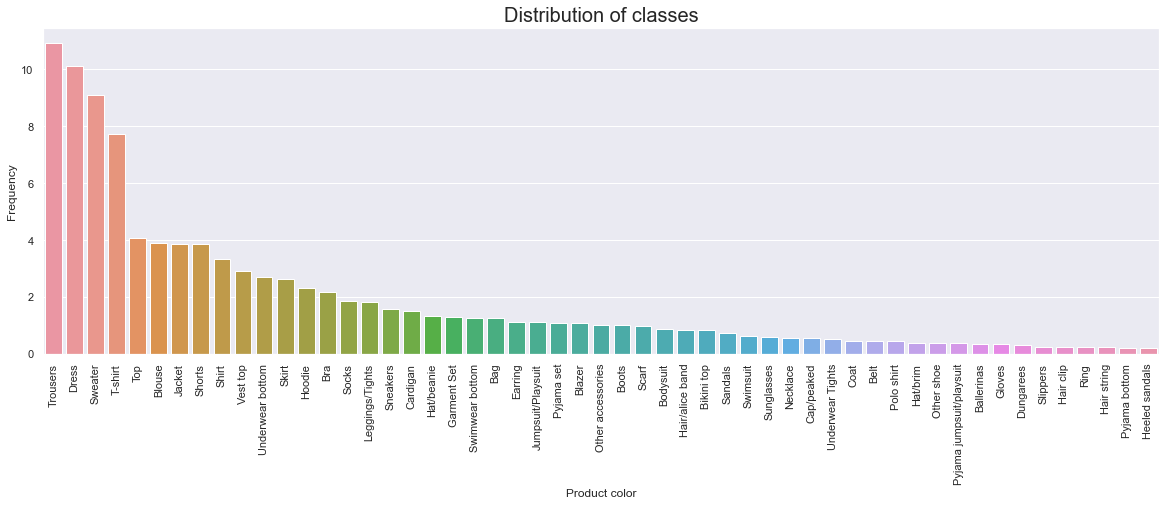

In [25]:
# Plot the distribution of product categories
ax = sns.set(rc={"figure.figsize":(20, 6)})
ax = sns.barplot(x='index', y='Percentage', data=class_percentages)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel ="Product color", ylabel = "Frequency")
ax.set_title('Distribution of classes', size = 20)
plt.show()

The most frequently occuring product category 'Trousers' and makes up 10.9% of the product categories, which means that guessing the category 'Trousers' should be correct 10.9% of the time. 

## 5. What are the most frequently occuring words in the product title and product descriptions?

In [29]:
def plot_wordcloud(text):
    stopwords = set(STOPWORDS)
    WordCloud().generate(text)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=800).generate(text)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

There are 1687809 words in the combination in column prod_name


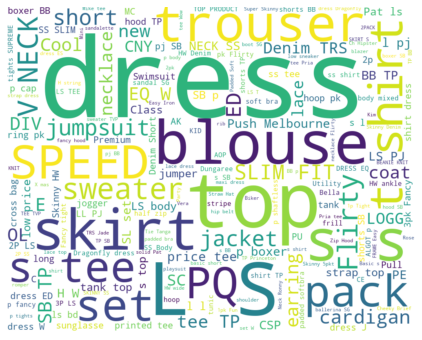

In [30]:
# Create a text list of all words in column 'prod_name'
title_text = " ".join(word for word in df.prod_name.astype(str))
print(f'There are {len(title_text)} words in the combination in column prod_name')
plot_wordcloud(title_text)

There are 14580247 words in the combination in column detail_desc


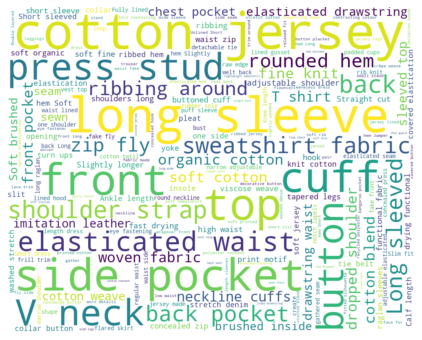

In [32]:
# Create a text list of all words in column 'detail_desc'
desc_text = " ".join(word for word in df.detail_desc.astype(str))
print(f'There are {len(desc_text)} words in the combination in column detail_desc')
plot_wordcloud(desc_text)

Word clouds of the most frequently occuring words in the product title and product descriptions show few similar results in each, but the product description word cloud shows more adjectives about fabric and clothing attirutes than nouns to describe what the product is. Thus, I suspect product title would have more information about the product category than the clothing attributes as they could apply to multiple different categories.

### Import image embeddings csv file
Due to the large number of images, the image embeddings were created in a separate jupyter notebook and done in batches and combined into a single dataframe. See the notebook here: [image embeddings notebook](https://github.com/melissavhan/H_and_M_product_category_classification/blob/03124bd14a6cc408ccabdb1301038b70dfa5ac58/notebooks/Capstone%203%20-%20Image%20embedding.ipynb)

In [33]:
# Open the image embeddings csv file
image_embedding = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/interim/combined_image_embeddings.csv', index_col='Unnamed: 0')
# Rename index to 'article_id' so it is consistent with the original dataset
image_embedding.index.names = ['article_id']
# Drop extra column
image_embedding.drop(['Unnamed: 0.1'], axis=1, inplace=True)


In [34]:
image_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
217207047,2.679361,0.306564,1.212155,1.188260,0.056715,0.022303,1.147643,0.293646,0.605903,0.052473,...,0.674172,1.723143,0.104001,0.674032,1.619033,0.617591,0.405708,0.362968,0.493930,2.490882
213691080,0.632062,0.070936,1.370101,3.107503,0.912835,0.019927,0.017866,0.426144,0.084189,0.150863,...,2.272056,0.204228,0.337832,0.126854,0.394283,1.328873,0.304165,0.058076,0.985178,0.030038
212629036,1.380411,0.093138,0.224101,0.026163,0.569458,0.200051,0.257274,0.116943,0.425302,0.499474,...,1.543374,0.145237,0.746950,0.624660,0.352762,0.159102,0.097694,1.121258,0.312964,0.272676
214844001,1.017763,0.094177,2.294733,1.414627,0.029835,1.086756,1.917363,0.509459,0.117570,0.075120,...,3.446632,1.106723,0.128347,1.110429,0.588763,0.000299,0.630921,0.190633,1.509852,3.986516
216081011,0.228950,0.253633,0.134512,0.161084,0.621370,0.850047,2.252668,1.000498,0.221402,0.535628,...,1.135270,0.017909,0.772394,0.775876,3.701260,0.668516,0.094508,0.876413,1.510044,1.602928


In [35]:
image_embedding.shape

(105100, 512)

In [36]:
df.shape

(102307, 24)

## 6. Visualizing high dimensional image embedding data
Use t-SNE to do dimensionality reduction to 2, so it can be plotted on a scatterplot

In [37]:
# Left join the image embedding df with the dataset to add product categories as a column
combined_image_embedding = image_embedding.join(df.product_type_name, how="left", on="article_id")

# Select only the rows that have product categories in the major_categories list
combined_image_embedding = combined_image_embedding[combined_image_embedding.product_type_name.isin(major_categories)]

# Group by product category and average columns
image_embedding_avg = combined_image_embedding.groupby('product_type_name').mean()
image_embedding_avg.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
product_type_name,,,,,,,,,,,,,,,,,,,,,
Bag,0.681212,0.443677,0.403611,0.931738,1.246021,1.551660,0.513118,1.334101,0.449637,0.420068,...,1.098513,1.420103,0.448688,0.636952,0.311516,0.857420,0.793789,0.630510,1.335264,1.001545
Ballerinas,0.513940,0.621714,0.815824,1.149757,0.811128,1.435429,0.746877,0.545549,0.421278,0.504909,...,0.771656,0.410308,0.438940,0.397616,0.367498,0.614346,1.667662,0.661890,2.061244,0.770567
Belt,0.709060,0.568910,0.281997,0.411133,0.817831,2.668674,0.814269,1.126784,0.099803,0.720789,...,1.593969,0.579796,0.485023,0.603288,0.249303,0.726571,0.655434,0.487558,1.504826,0.557466
Bikini top,1.263963,0.143957,0.738942,0.848450,0.379502,0.432734,0.572623,0.902709,0.862080,0.219059,...,0.544743,2.065787,0.547427,0.677926,0.543219,2.336209,1.313685,1.693887,0.928250,1.352857
Blazer,0.870944,0.164374,0.539116,0.298934,0.454228,0.480050,0.796305,0.243196,0.257804,0.758694,...,1.492303,0.171747,0.686801,0.793217,3.410704,0.313022,0.501967,0.687012,0.518325,1.316040


In [38]:
# Use t-SNE to do dimensionality reduction to 2 
model = TSNE(n_components=2,perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(image_embedding_avg)
print(tsne_data.shape)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(53, 2)


In [39]:
# Let's look at the top 20 major product categories
tsne_data = pd.DataFrame(tsne_data[:20])
tsne_data.columns = ['Dimension_1', 'Dimension_2']
tsne_data

,Dimension_1,Dimension_2
0,27.201876,-18.498854
1,-35.734375,-45.063194
2,13.123237,-93.252106
3,45.181034,-30.864817
4,-65.280037,53.655090
5,-53.021595,6.853670
6,24.925232,4.894233
7,-41.521076,-65.821632
8,77.195778,39.458206
9,12.023789,-30.547050


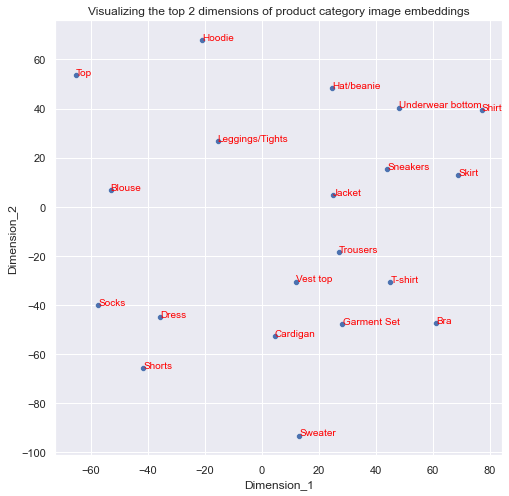

In [40]:
# Plot as scatterplot each product category and the categories that are close to each other should be similar in distance
sns.set(rc={"figure.figsize":(8, 8)})
sns.scatterplot(data=tsne_data, x='Dimension_1', y='Dimension_2').set(title='Visualizing the top 2 dimensions of product category image embeddings')
for i in range(tsne_data.shape[0]):
    plt.text(x=tsne_data['Dimension_1'][i]+0.02, y=tsne_data['Dimension_2'][i]+0.01, s=major_categories[i], 
          fontdict=dict(color='red',size=10))


The scatterplot shoes some clustering of product categories such as top, hoodie, blouse. But there are other categories that don't seem to have a relationship such as socks, dress, shorts.

## 7. Compare the number of images vs. the number of products
Each product should have a corresponding product image

In [41]:
# Check the number of images in file directory vs. the number of products under article_id?
# Do a left join to see which rows are missing images
combineddf = df.join(image_embedding, how="left", on="article_id")
# Select the rows where there is product text but no image
combineddf[combineddf['511'].isnull() == True]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
174057028,174057,FLEECE PYJAMA,295,Pyjama jumpsuit/playsuit,Nightwear,1010001,All over pattern,51,Light Pink,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179208001,179208,Control Top 100 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212042043,212042,Mimmi sneaker,94,Sneakers,Shoes,1010016,Solid,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212042066,212042,Mimmi sneaker,94,Sneakers,Shoes,1010016,Solid,22,Yellow,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212629004,212629,Alcazar strap dress,265,Dress,Garment Full body,1010016,Solid,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877369001,877369,CHERRY JRSY,275,Skirt,Garment Lower body,1010004,Check,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880333001,880333,Violet LS,254,Top,Garment Upper body,1010016,Solid,10,White,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901588001,901588,Barbie Dress,265,Dress,Garment Full body,1010006,Dot,51,Light Pink,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Save a list of the article_id products that are missing images
missing_images = list(combineddf[combineddf['511'].isnull() == True].index)

print(f'There are a total of {len(missing_images)} images missing from the dataset')
# Since this is a small fraction of the dataset, drop these rows from the dataset. 
df.drop(index=missing_images, inplace=True)

There are a total of 417 images missing from the dataset


/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_48914/1875852106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=missing_images, inplace=True)


In [43]:
# Do a left join to see which rows are missing images
combineddf_1 = df.join(image_embedding, how="left", on="article_id")
# Select the rows where there is product text but no image
combineddf_1[combineddf_1['511'].isnull() == True]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,


All rows have an associated image

## 8. Drop null values

In [44]:
combineddf.isna().sum()

product_code            0
prod_name               0
product_type_no         0
product_type_name       0
product_group_name      0
                     ... 
507                   417
508                   417
509                   417
510                   417
511                   417
Length: 536, dtype: int64

In [45]:
combineddf.dropna(inplace=True)
combineddf.isna().sum()

product_code          0
prod_name             0
product_type_no       0
product_type_name     0
product_group_name    0
                     ..
507                   0
508                   0
509                   0
510                   0
511                   0
Length: 536, dtype: int64

In [46]:
combineddf.shape

(101890, 536)

In [47]:
# Save file as csv
combineddf.to_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/interim/H_and_M_dataset.csv')
print('Saved to file')

Saved to file
